In [16]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU,Add
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.metrics import BinaryAccuracy, Precision, MeanIoU, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import seaborn as sns
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import datetime
from keras.utils import plot_model

In [ ]:
!pip install tensorflow tensorboard

In [ ]:
!pip install visualkeras

In [ ]:
!pip install pydot

In [18]:
!pip install netron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.4 MB/s eta 0:00:00


In [3]:
import visualkeras

#Encoder/Decoder blocks

In [4]:
def down_block(input,start_neurons):
    conv = Conv2D(start_neurons, (3, 3), activation='relu', padding='same')(input)
    conv = BatchNormalization()(conv)
    conv = Conv2D(start_neurons, (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)

    return conv , pool


def up_block(input,skip_features,start_neurons):
    up = concatenate([Conv2DTranspose(start_neurons, (2, 2), strides=(2, 2), padding='same')(input), skip_features], axis=3)
    conv = Conv2D(start_neurons , (3, 3), activation='relu', padding='same')(up)
    conv = BatchNormalization()(conv)
    conv = Conv2D(start_neurons , (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)

    return conv


def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)

    return y

downsampler plot

In [105]:
from collections import defaultdict
color_map = defaultdict(dict)
color_map[Input]['fill'] = 'coral'
color_map[Conv2D]['fill'] = 'red'
color_map[Conv2DTranspose]['fill'] = 'gray'
color_map[MaxPooling2D]['fill'] = 'lightgoldenrodyellow'
color_map[BatchNormalization]['fill'] = 'lightgreen'
color_map[Concatenate]['fill'] = 'seagreen'

In [8]:
Inputs = Input((256,256,1))

In [11]:
conv, pool = down_block(Inputs,32)
down = Model(inputs = [Inputs], outputs = [pool])

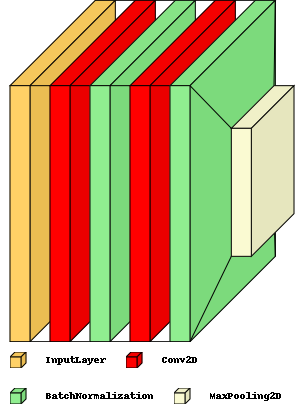

In [118]:
visualkeras.layered_view(down, legend=True, draw_volume=True, scale_xy=1, scale_z=0.5, color_map=color_map, spacing=20)

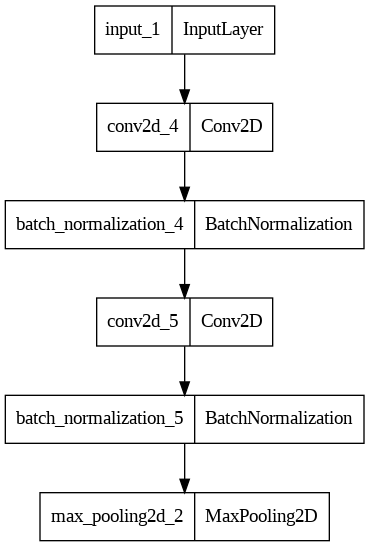

In [85]:
plot_model(down)

up sampler plot

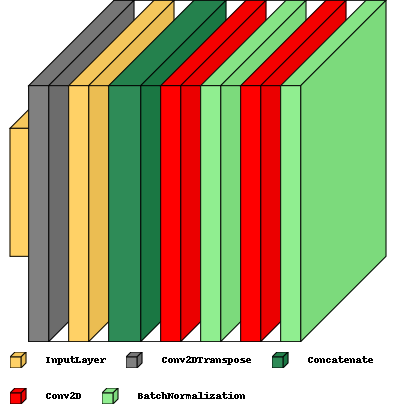

In [117]:
uconv = up_block(pool,conv,32)
up = Model(inputs = [conv,pool], outputs = [uconv])
visualkeras.layered_view(up, legend=True, draw_volume=True, scale_xy=1, scale_z=0.5, color_map=color_map, spacing=20)

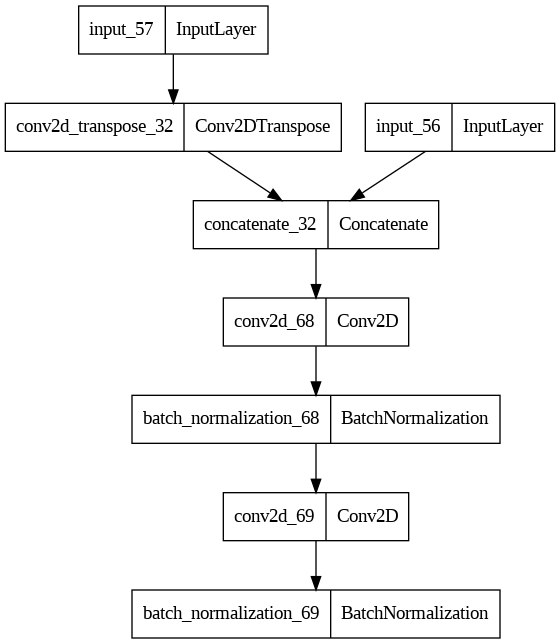

In [119]:
plot_model(up)

middle block plot

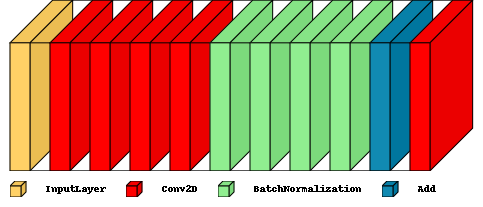

In [121]:
y = aspp_block(pool,32)
aspp = Model(inputs = [pool], outputs = [y])
visualkeras.layered_view(aspp, legend=True, draw_volume=True, scale_xy=1, scale_z=0.5, color_map=color_map, spacing=20)

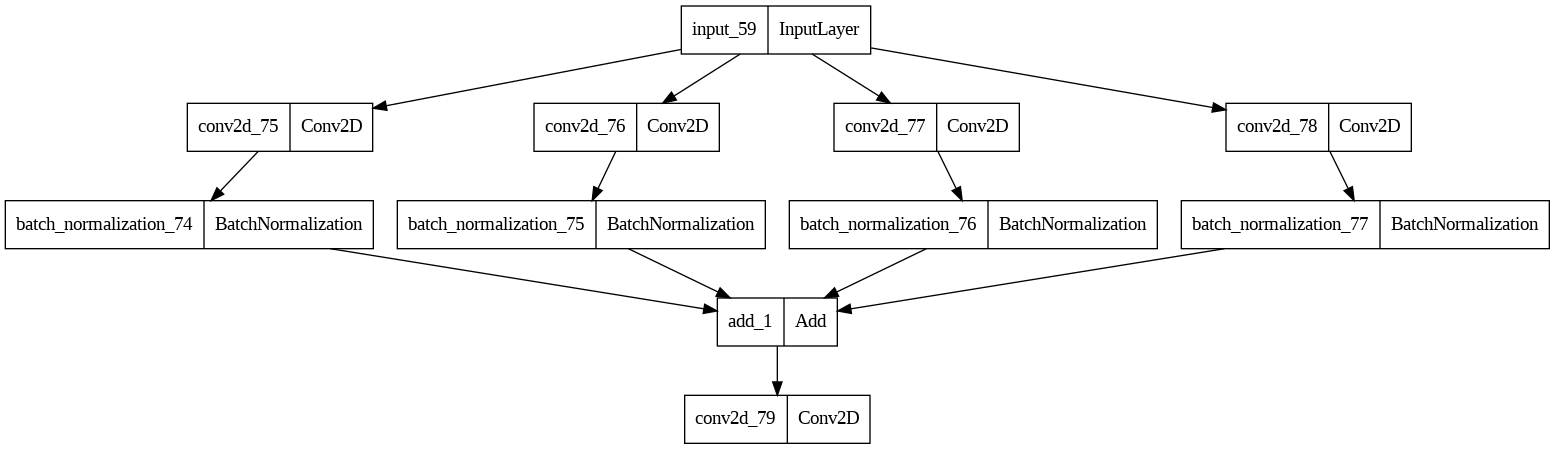

In [122]:
plot_model(aspp)

#**Basic Unet**

In [129]:
def unet(input_size = (256,256,1) , start_neurons = 32 , optimizer='adam', loss='binary_crossentropy'):

    inputs = Input(input_size)
    #downblocks
    conv1 , pool1 = down_block(inputs, start_neurons * 1)
    conv2 , pool2 = down_block(pool1, start_neurons * 2)
    conv3 , pool3 = down_block(pool2, start_neurons * 4)
    conv4 , pool4 = down_block(pool3, start_neurons * 8) 


    #middle (we don't need pool in the middle)
    mconv = aspp_block(pool4, start_neurons * 16)
    #mconv, _ = down_block(pool4 , start_neurons * 16)

    #upblocks
    uconv4 = up_block(mconv , conv4 , start_neurons * 8)
    uconv3 = up_block(uconv4, conv3 , start_neurons * 4)
    uconv2 = up_block(uconv3 , conv2 , start_neurons * 2)
    uconv1 = up_block(uconv2 , conv1 , start_neurons * 1)

    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(uconv1)

    model = Model(inputs=[inputs], outputs=[output_layer])
    
    return model

In [130]:
bsic_unet = unet()

In [138]:
bsic_unet.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_61 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 256, 256, 32  320         ['input_61[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_98 (BatchN  (None, 256, 256, 32  128        ['conv2d_102[0][0]']             
 ormalization)                  )                                                          

In [139]:
print(len(bsic_unet.layers))

56


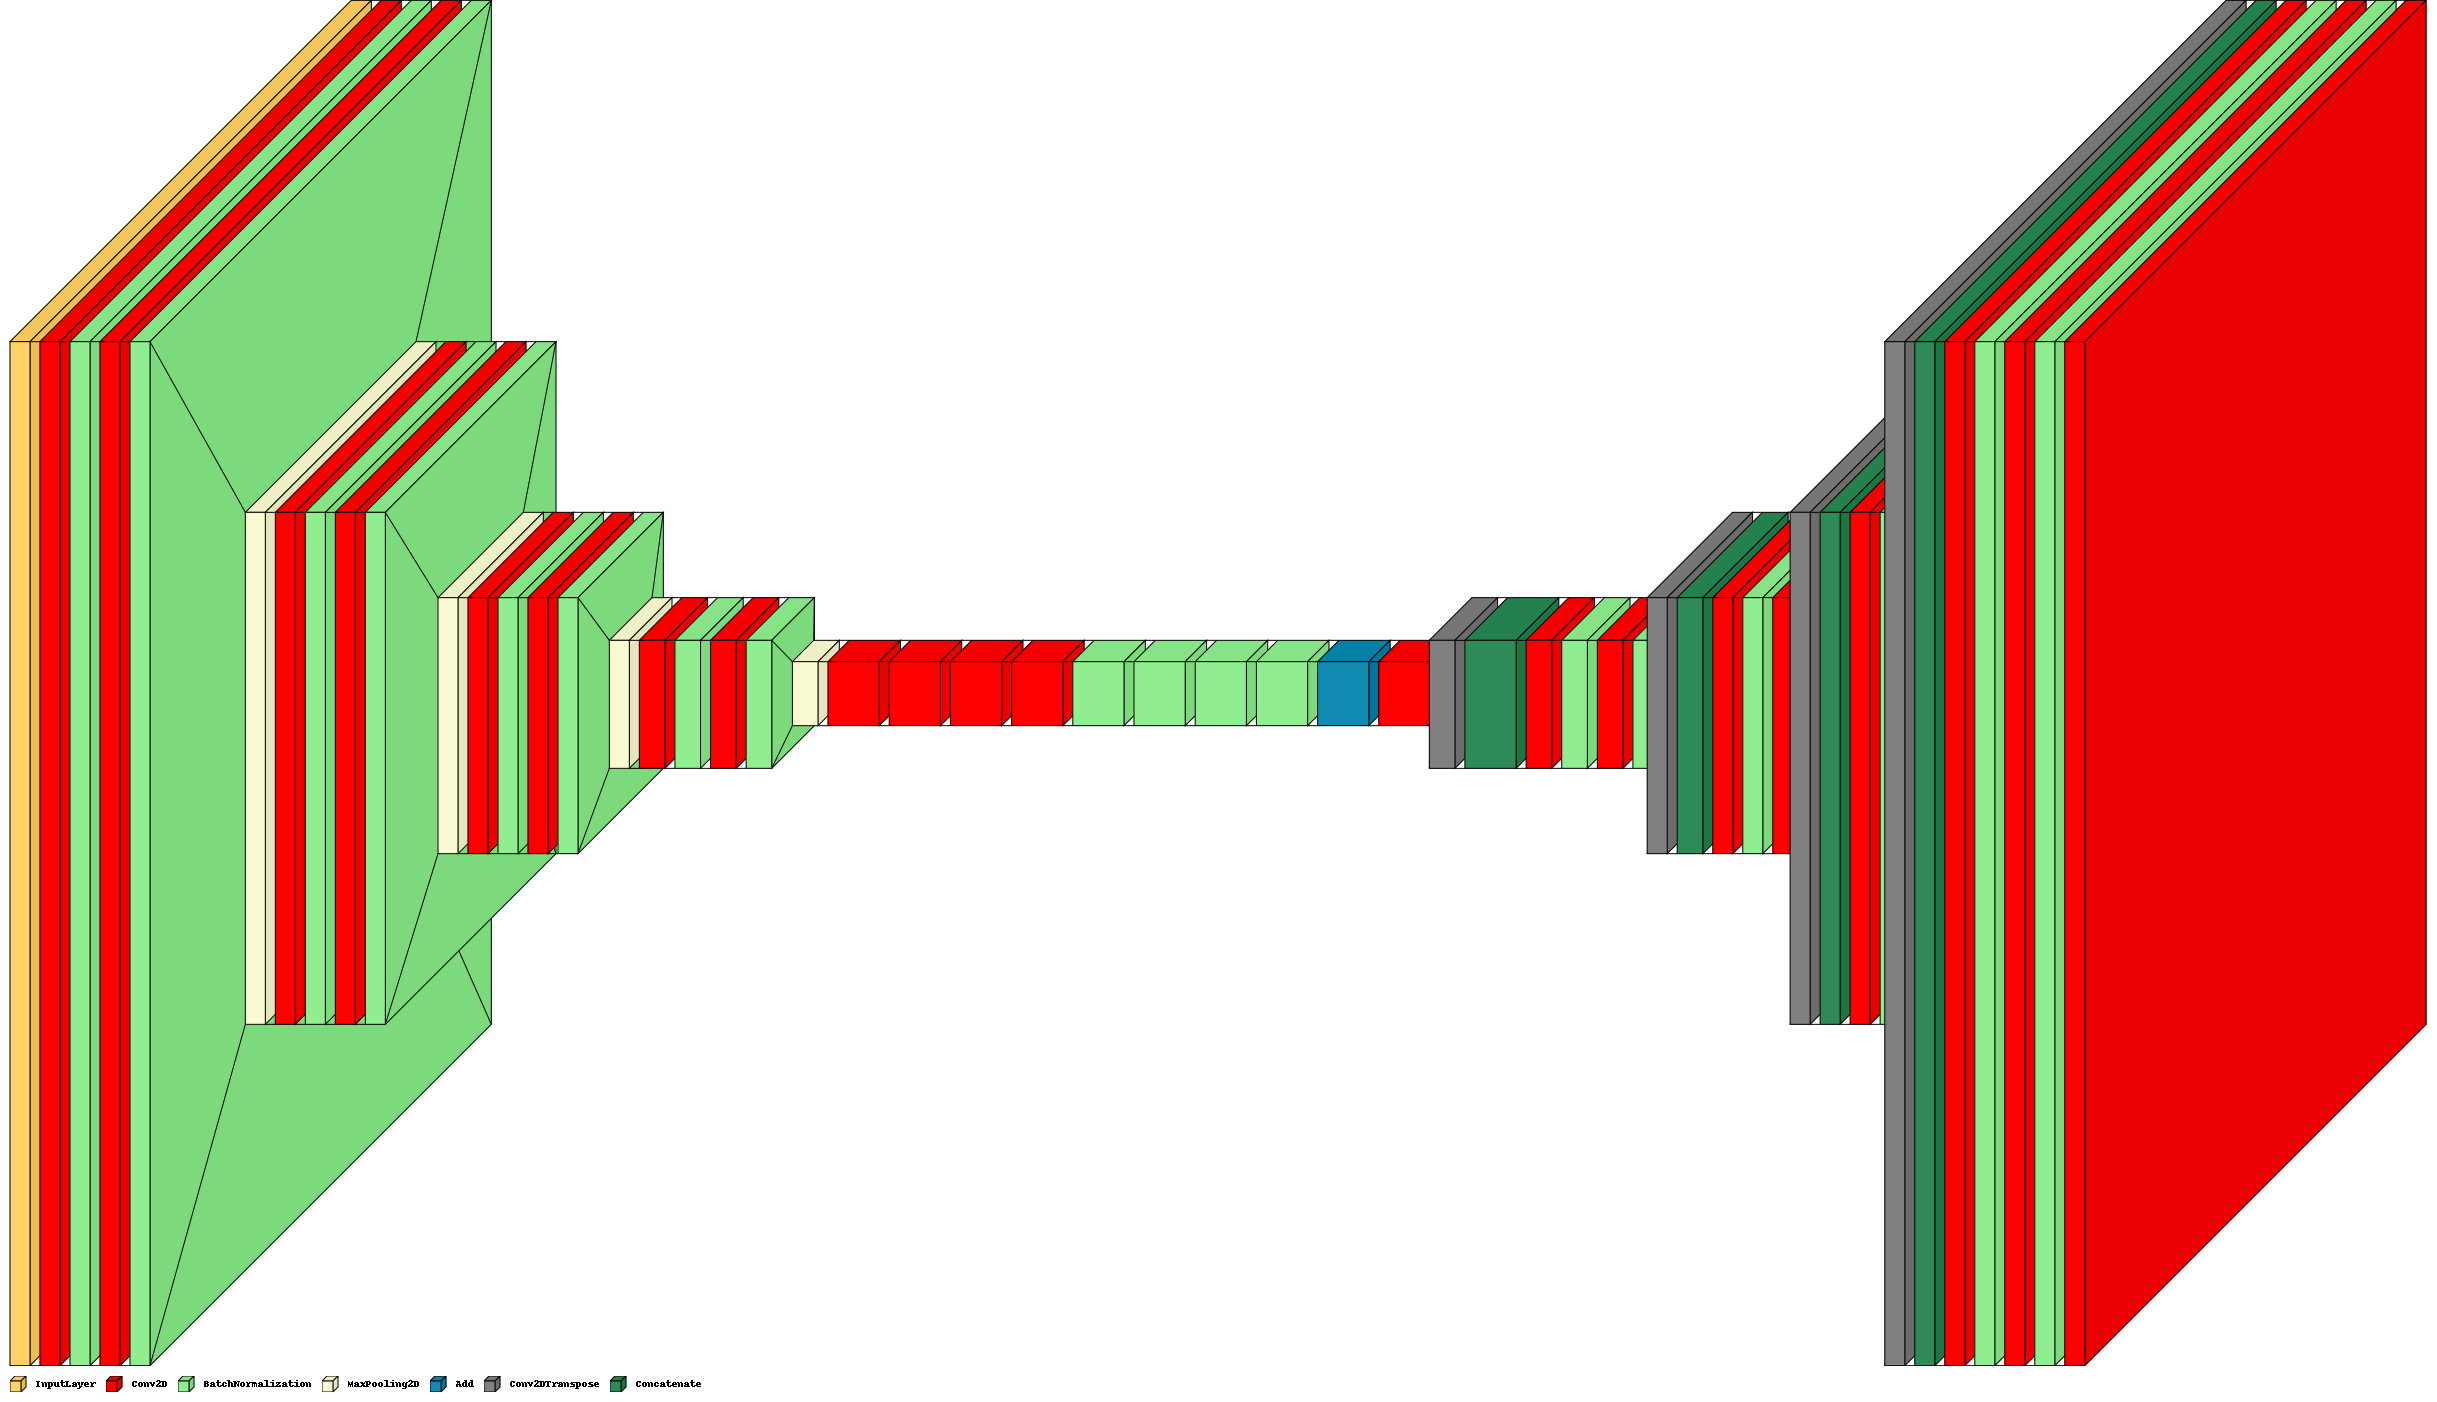

In [140]:
visualkeras.layered_view(bsic_unet, legend=True, draw_volume=True, color_map=color_map)

#Extended Unet

In [141]:
def down_block_ext(input,start_neurons):
    conv = Conv2D(start_neurons, (3, 3), activation='relu', padding='same')(input)
    conv = BatchNormalization()(conv)
    conv = Conv2D(start_neurons, (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    pool = Dropout(0.1)(pool)

    return conv , pool


def up_block_ext(input,skip_features,start_neurons):
    up = concatenate([Conv2DTranspose(start_neurons, (2, 2), strides=(2, 2), padding='same')(input), skip_features], axis=3)
    conv = Dropout(0.1)(up)
    conv = Conv2D(start_neurons , (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Conv2D(start_neurons , (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)

    return conv

def unet_ext(input_size = (256,256,1) , start_neurons = 32):

    inputs = Input(input_size)

    #downblocks
    conv1 , pool1 = down_block_ext(inputs, start_neurons * 1)
    conv2 , pool2 = down_block_ext(pool1, start_neurons * 2)
    conv3 , pool3 = down_block_ext(pool2, start_neurons * 4)
    conv4 , pool4 = down_block_ext(pool3, start_neurons * 8) 
    conv5 , pool5 = down_block_ext(pool4, start_neurons * 16)
    conv6 , pool6 = down_block_ext(pool5, start_neurons * 32)

    #middle (we don't need pool in the middle)
    mconv, _ = down_block_ext(pool6 , start_neurons * 64)

    #upblocks
    uconv6 = up_block_ext(mconv, conv6 , start_neurons * 32)
    uconv5 = up_block_ext(uconv6, conv5 , start_neurons * 16)
    uconv4 = up_block_ext(uconv5 , conv4 , start_neurons * 8)
    uconv3 = up_block_ext(uconv4, conv3 , start_neurons * 4)
    uconv2 = up_block_ext(uconv3 , conv2 , start_neurons * 2)
    uconv1 = up_block_ext(uconv2 , conv1 , start_neurons * 1)

    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(uconv1)

    model = Model(inputs=[inputs], outputs=[output_layer])
    return model



In [152]:
ext_unet = unet_ext(start_neurons = 16)

In [153]:
print(len(ext_unet.layers))

84


In [154]:
ext_unet.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_201 (Conv2D)            (None, 256, 256, 16  160         ['input_65[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 256, 256, 16  64         ['conv2d_201[0][0]']             
 Normalization)                 )                                                          

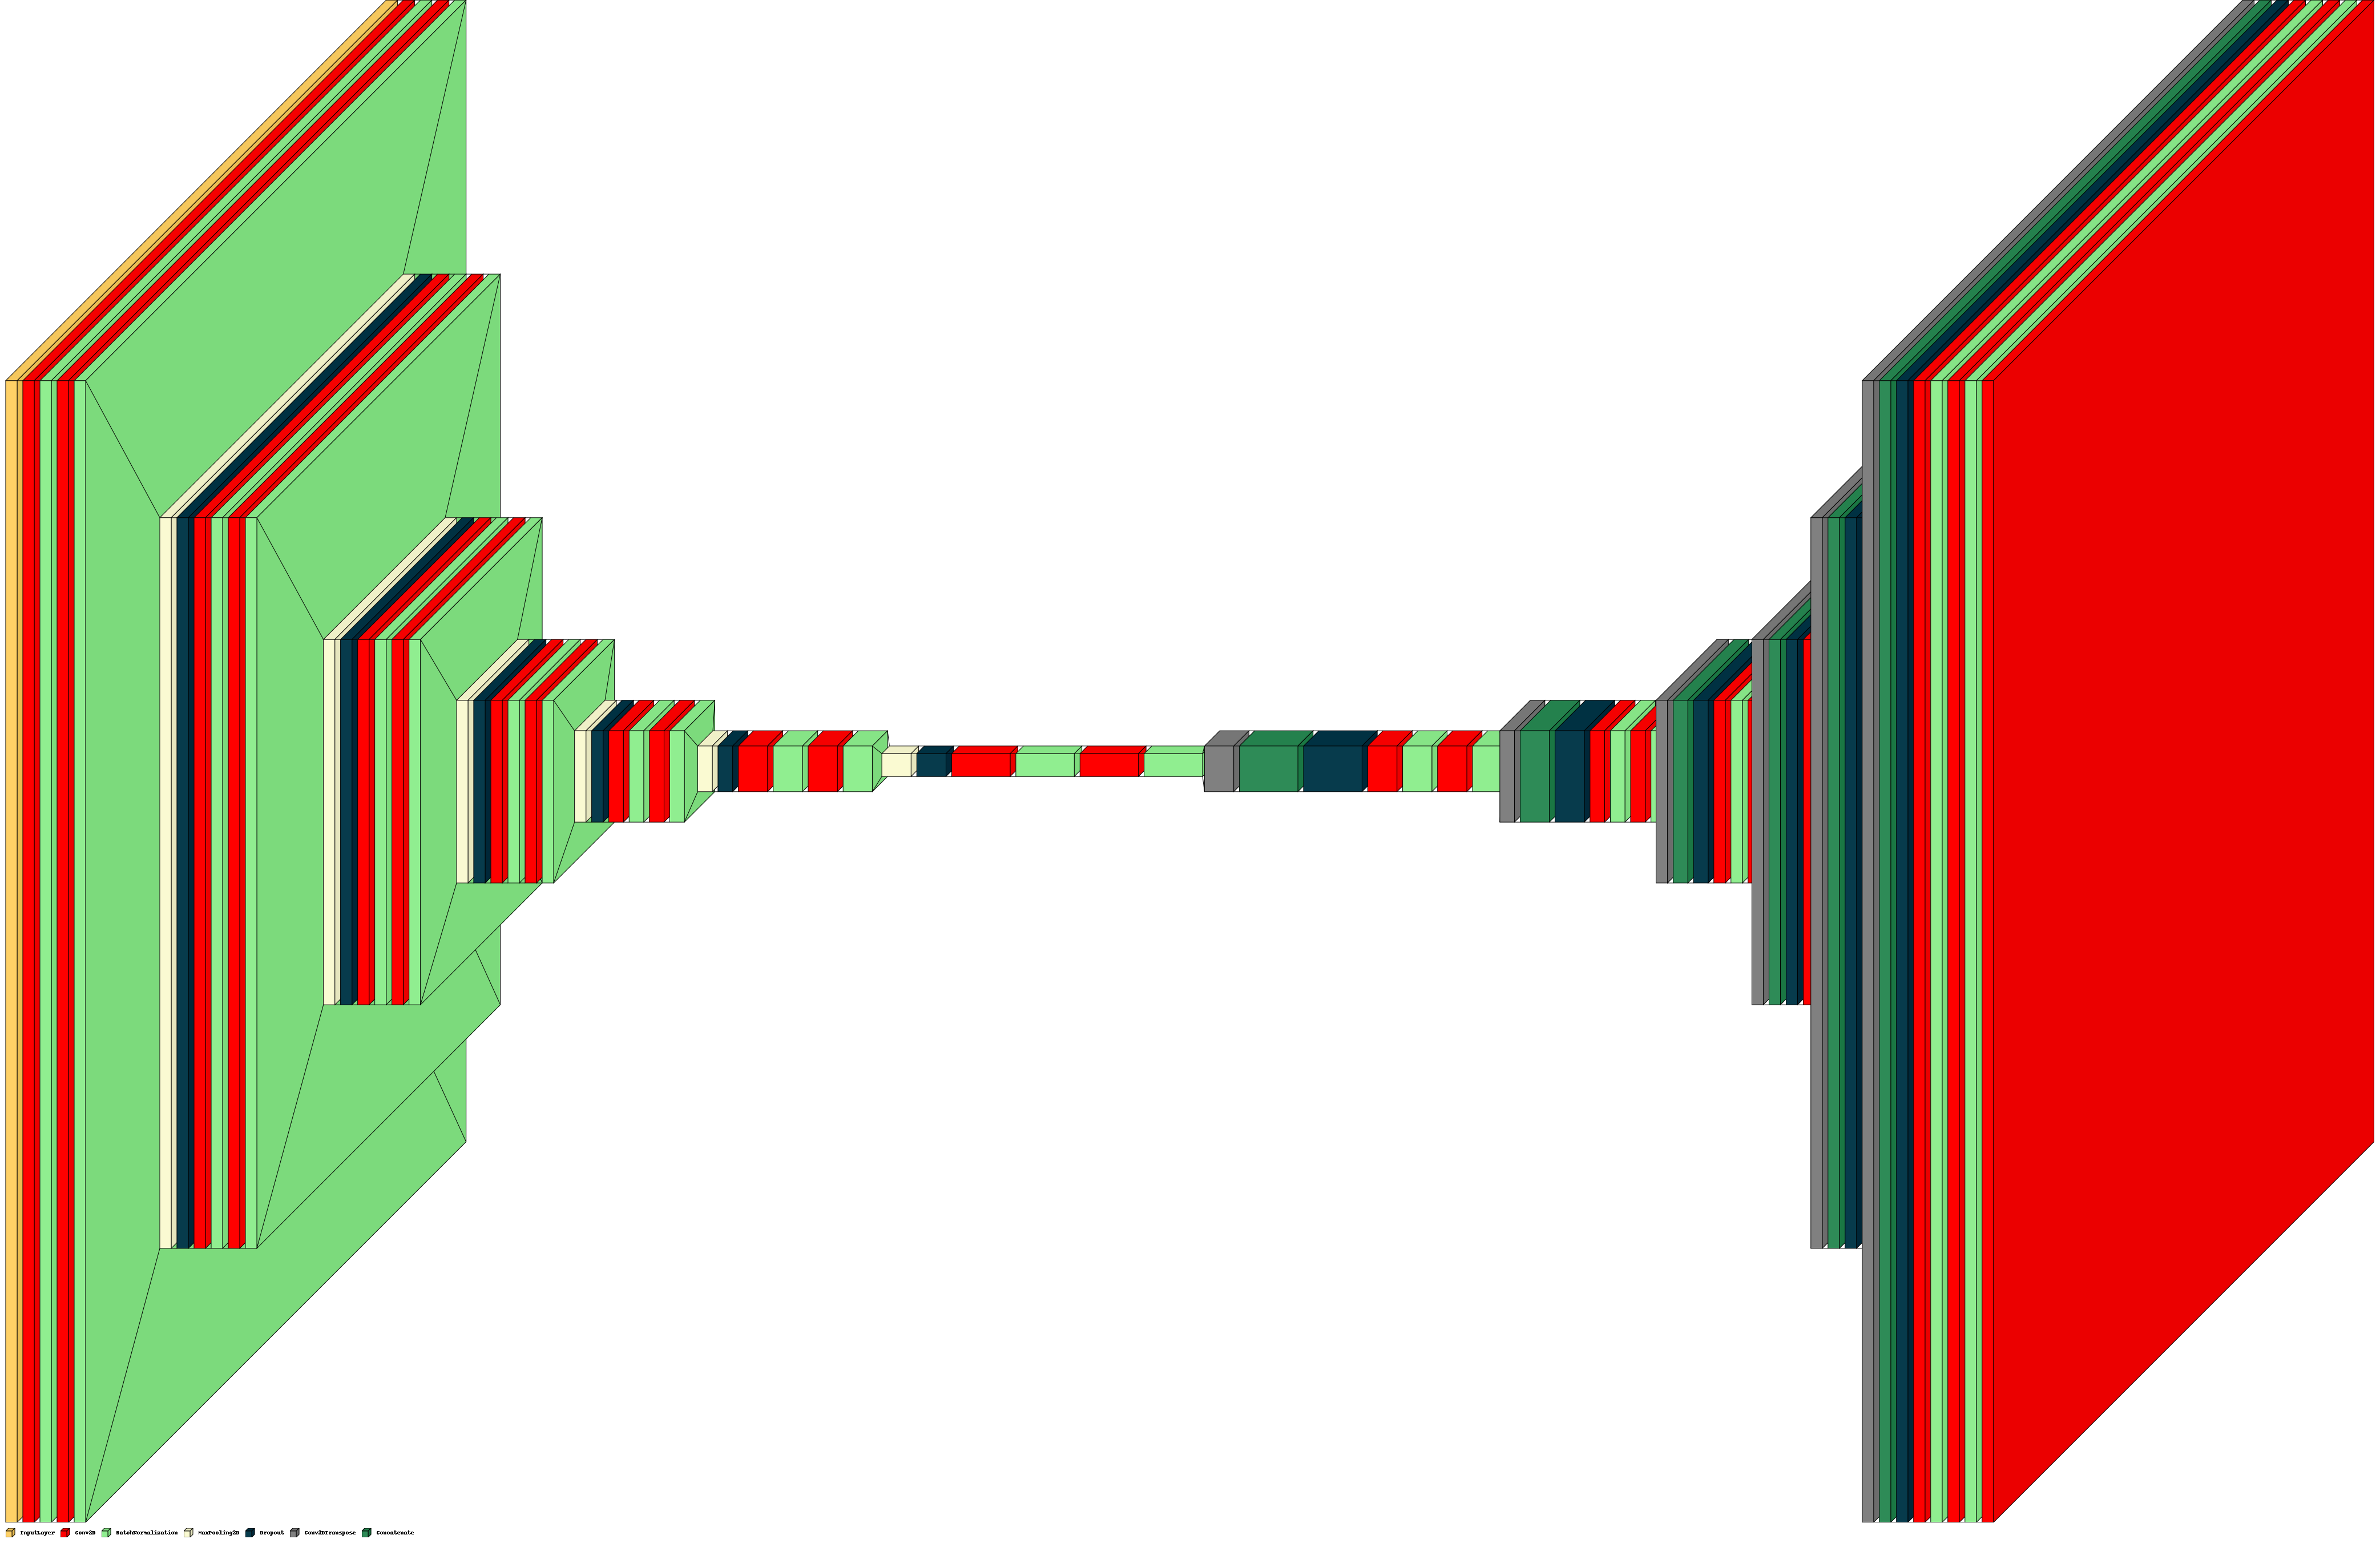

In [172]:
visualkeras.layered_view(ext_unet, legend=True, draw_volume=True,scale_xy=10,color_map=color_map)

#Connected Unet

In [156]:
def unet_block(input ,input_size = (256,256,1) , start_neurons = 16):

    #downblocks
    conv1 , pool1 = down_block(input, start_neurons * 1)
    conv2 , pool2 = down_block(pool1, start_neurons * 2)
    conv3 , pool3 = down_block(pool2, start_neurons * 4)
    conv4 , pool4 = down_block(pool3, start_neurons * 8) 


    #middle (we don't need pool in the middle)
    mconv = aspp_block(pool4, start_neurons * 16)
    #mconv, _ = down_block(pool4 , start_neurons * 16)

    #upblocks

    uconv4 = up_block(mconv , conv4 , start_neurons * 8)
    uconv3 = up_block(uconv4, conv3 , start_neurons * 4)
    uconv2 = up_block(uconv3 , conv2 , start_neurons * 2)
    uconv1 = up_block(uconv2 , conv1 , start_neurons * 1)


    return uconv1


def connected_unet(input_size = (256,256,1) , start_neurons = 32):
  inputs = Input(input_size)

  unet_1 = unet_block(inputs,input_size , start_neurons)

  unet_middle = concatenate([Conv2D(start_neurons, (3, 3), activation='relu', padding='same')(unet_1), unet_1], axis=3)

  unet_2 = unet_block(unet_1, input_size, start_neurons )

  aspp = aspp_block(unet_2, start_neurons)

  output_layer = Conv2D(1, (1, 1), activation='sigmoid')(aspp)

  model = Model(inputs=[inputs], outputs=[output_layer])

  return model

In [157]:
con_unet = connected_unet()

In [158]:
print(len(con_unet.layers))

120


In [159]:
con_unet.summary()

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_228 (Conv2D)            (None, 256, 256, 32  320         ['input_66[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_214 (Batch  (None, 256, 256, 32  128        ['conv2d_228[0][0]']             
 Normalization)                 )                                                          

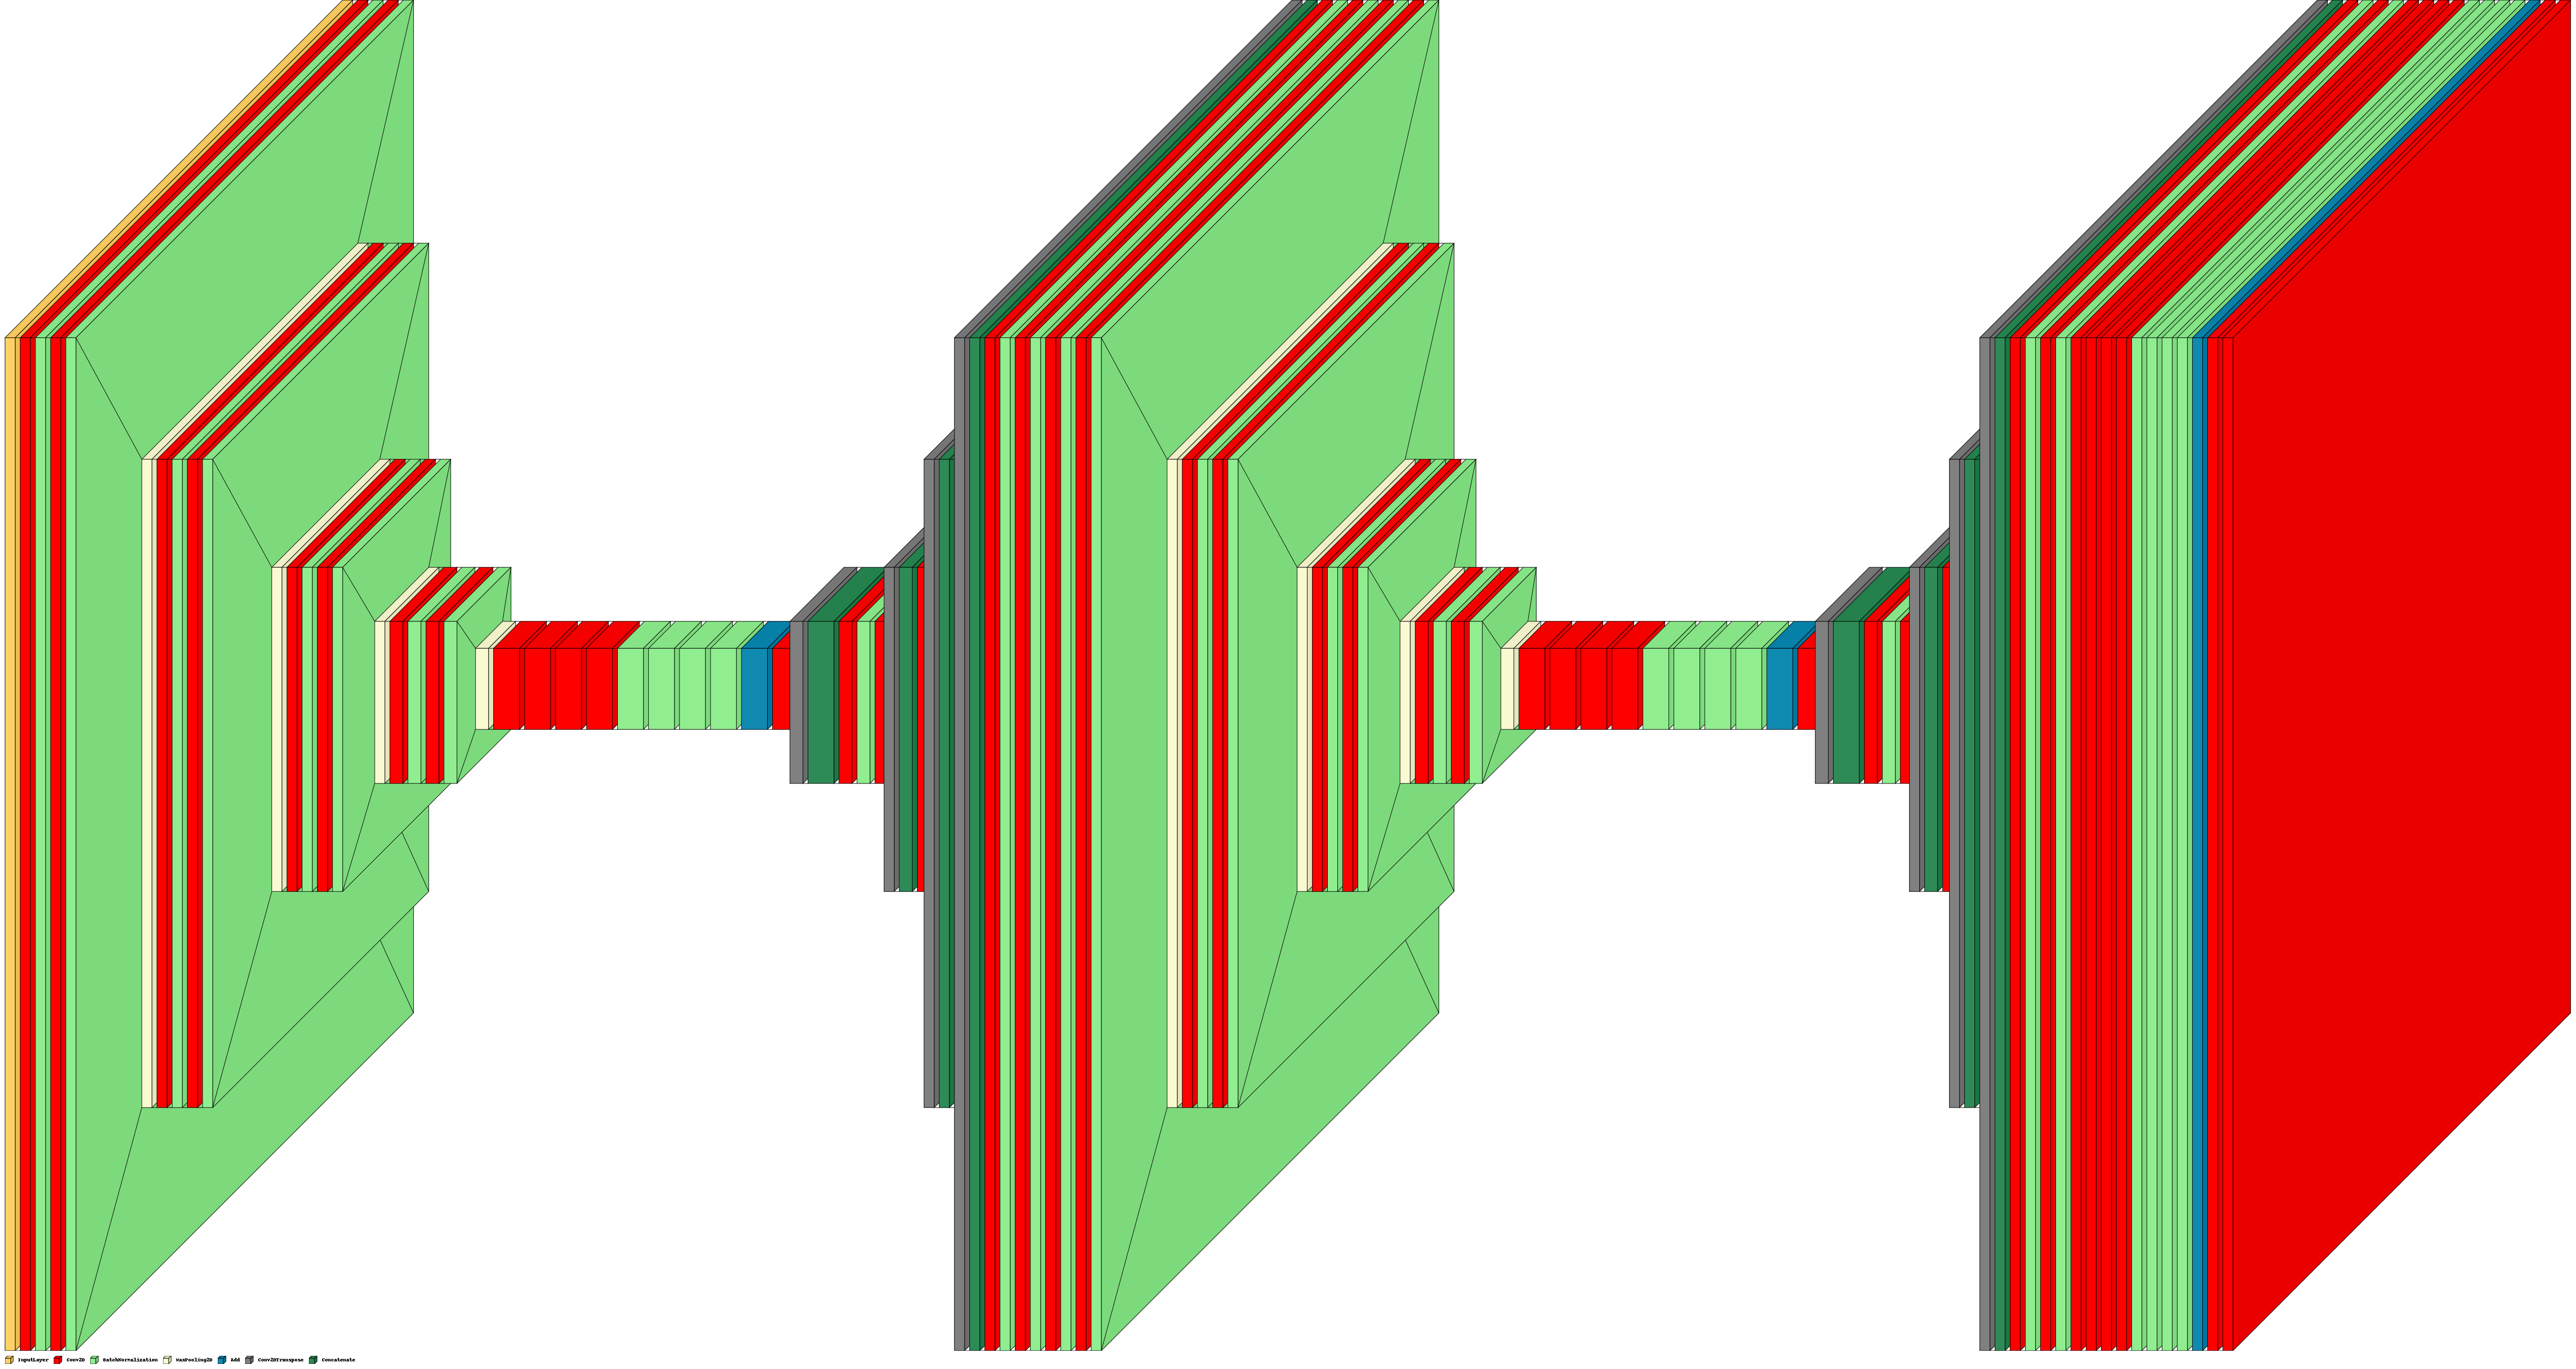

In [163]:
visualkeras.layered_view(con_unet, legend=True, draw_volume=True,scale_xy=10, color_map=color_map)